In [1]:
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from os.path import exists
import random

#GP
import sklearn
from sklearn import preprocessing
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import PredictionErrorDisplay


#LHC sampling 
from scipy.stats import qmc

#map
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

#homemade function file
import importlib
import ppe_loading_functions #as functions
importlib.reload(ppe_loading_functions)
import ref_data_functions #as functions
importlib.reload(ref_data_functions)


import matplotlib.colors as mcolors
mcolors.CSS4_COLORS

colors=['c', 'b', 'm', 'k', 'y', 'gray','lightcoral', 'dodgerblue', 'blueviolet']
shapes=['.', '*', '+', '>', '<', 's','-.', 'o']

# Load ICON PPEs

In [2]:
var1stPPE, results1stPPE,var2ndPPE, results2ndPPE, varMoreCloudParam, resultsMoreCloudParam,\
 varMoreCloudParam2, resultsMoreCloudParam2, varPhyDyn_NewParam_2tun,resultsPhyDyn_NewParam_2tun,\
 varPhyDyn_NewParam_5thPPE_2tun,results_5thPPE_2tun=\
ppe_loading_functions.load_all_ppes()

In [3]:
#Ref tuned ICON-A 2.6.4
pressure_addi,pressure_fact,tauufact,aes_glo_psl,aes_SOO_tauu,aes_NAO_tauu,aes_60N_1000hPa_ua,aes_60S_1000hPa_ua,\
aes_60N_10hPa_ua,aes_60S_10hPa_ua=ref_data_functions.ICON_aes_refdata()

In [4]:
#Physics Ref
ref_mean, ref_std=ref_data_functions.References_outputs()
#Dynamics Ref
refsERA5, refsMERRA2, refsERAInterim=ref_data_functions.References_Dynoutputs()

#all ref values for Physics and Dynamic variables
ref2tun_mean=np.zeros(9)
ref2tun_mean[0:5]=ref_mean #physics variables
ref2tun_mean[5:]=[refsERA5[0],refsERA5[1],refsERA5[2],refsERA5[3]] #dynamics variables
#ref_mean
print(ref2tun_mean)

#all std for Physics and Dynamic variables: not used yet in the HM flow

/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:26: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ref_TOASW=file['gsolar_clim'][:]-file['gtoa_sw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:26: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  ref_TOASW=file['gsolar_clim'][:]-file['gtoa_sw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:27: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ref_TOALW=-file['gtoa_lw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:27: UserWarnin

[ 2.40866470e+02 -2.40114889e+02  5.00000000e-01  6.74343643e+01
  2.44086728e+01  1.09413767e+01  3.27732849e+01  2.94719753e-03
  1.36748120e-01]


/home/b/b309216/kernels/my-kernel/lib/python3.8/site-packages/iris/analysis/cartography.py:412: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


In [5]:
ref_Clt_ESACCI, ref_Clt_ESACCI_std, ref_Clt_CLARA_AVHRR, ref_Clt_CLARA_AVHRR_std=ref_data_functions.Ref_clt()
ref_Prw_ESACCI, ref_Prw_ERA5, ref_Prw_ERA5_std=ref_data_functions.Ref_prw()

In [6]:
years_clt_esacci,clt_esacci_per_year=ref_data_functions.clt_esacci_per_years()
years_clt_claraavhrr,clt_claraavhrr_per_year=ref_data_functions.clt_claraavhrr_per_years()
years_prw_era5,prw_era5_per_year=ref_data_functions.prw_era5_per_years()

In [7]:
#reference data 2nd tuning step
ref2tun_mean=ref_data_functions.era5_data()

/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:26: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ref_TOASW=file['gsolar_clim'][:]-file['gtoa_sw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:26: UserWarning: WARNING: valid_max not used since it
cannot be safely cast to variable data type
  ref_TOASW=file['gsolar_clim'][:]-file['gtoa_sw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:27: UserWarning: WARNING: valid_min not used since it
cannot be safely cast to variable data type
  ref_TOALW=-file['gtoa_lw_all_clim'][:] #m/W^2
/home/b/b309216/bonnet23_gmd_automatic_tuning_atm_paper/Paper_clean_code/D-read_and_analyze_output_data/ref_data_functions.py:27: UserWarnin

# GP

In [8]:
# train the GP on the training sample

results=np.concatenate((results1stPPE,results2ndPPE),axis=0) #phy
var1=np.concatenate((var1stPPE,var2ndPPE),axis=0)

kernel = 1 * Matern(length_scale=1.0, nu=1.5) #RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) #np.array([1.0,1.0,1.0])) #length_scale=10) # ,1.0,1.0,1.0]))#, length_scale_bounds=(1e-2, 1e2))
gaussian_process_multi = GaussianProcessRegressor(kernel=kernel,alpha=1e-5, n_restarts_optimizer=20)

#scale data https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
scaler_var1 = preprocessing.StandardScaler().fit(var1)
scaled_var1 = scaler_var1.transform(var1)

gaussian_process_multi.fit(scaled_var1, results) #
gaussian_process_multi.kernel_

score=cross_val_score(gaussian_process_multi, scaled_var1, results)
print('gaussian_process_multi, cross val score:', np.mean(score))#, "get_param",GP1.get_params())

gaussian_process_multi, cross val score: 0.7875186065246212


In [9]:
nparam=6
Nsize=100
Emid_VAR=np.linspace(1e-4,4e-4,Nsize) #, '2e-4']
Epen_VAR=np.linspace(5e-5,4e-4,Nsize) #
Edd_VAR=np.linspace(1e-4,4e-4,Nsize)
Taumf_VAR=np.linspace(1800, 7200,Nsize)
Pr_VAR = np.linspace(0.7,1,Nsize) #
R0top_VAR=np.linspace(5e-1, 9e-1,Nsize)

def synthe_all_no(ii,indbounds):
    print(ii)
    if indbounds==0:    
        Emid_bounds = ['1e-4']  #, '2e-4']
        Epen_bounds = ['5e-5']  #,'2e-4'] #Epen = ['1e-4', '2e-4','6e-4']
        Edd_bounds = ['1e-4']   #, '4e-4']
        Taumf_bounds = ['1800'] #, 7200,100)
        Pr_bounds = ['0.7']     #, '1']# ['1']
        R0top_bounds = ['5e-1']# 8e-1
    if indbounds==1:    
        Emid_bounds = ['4e-4']  #, '2e-4']
        Epen_bounds = ['4e-4']  #,'2e-4'] #Epen = ['1e-4', '2e-4','6e-4']
        Edd_bounds = ['4e-4']   #, '4e-4']
        Taumf_bounds = ['7200'] #, 7200,100)
        Pr_bounds = ['1']     #, '1']# ['1']
        R0top_bounds = ['9e-1']# 8e-1
    if indbounds==2:    
        Emid_bounds = ['0.00028526']#['2.5e-4']  #, '2e-4']
        Epen_bounds = ['9.2951e-5']#['2.5e-4']  #,'2e-4'] #Epen = ['1e-4', '2e-4','6e-4']
        Edd_bounds = ['0.0001766']   #, '4e-4']
        Taumf_bounds = ['2114.57'] #, 7200,100)
        Pr_bounds = ['0.93168']     #, '1']# ['1']
        R0top_bounds = ['0.6071']# 8e-1
       
    if ii==0:
        Emid_bounds=Emid_VAR
    if ii==1:
        Epen_bounds=Epen_VAR
    if ii==2:
        Edd_bounds=Edd_VAR
    if ii==3:
        Taumf_bounds=Taumf_VAR
    if ii==4:
        Pr_bounds = Pr_VAR
    if ii==5:
        R0top_bounds=R0top_VAR

    nsimu=len(Emid_bounds)*len(Epen_bounds)*len(Edd_bounds)*len(Taumf_bounds)*len(Pr_bounds)*len(R0top_bounds)
    synthe_paramnorma=np.zeros((nsimu,nparam,))
    isimu=0
    nzero=0
    for Emid_bounds_ in Emid_bounds:
        for Epen_bounds_ in Epen_bounds:
            for Edd_bounds_ in Edd_bounds:
                for Taumf_bounds_ in Taumf_bounds:
                    for Pr_bounds_ in Pr_bounds:
                        for R0top_bounds_ in R0top_bounds:
                            synthe_paramnorma[isimu,0]=Emid_bounds_
                            synthe_paramnorma[isimu,1]=Epen_bounds_
                            synthe_paramnorma[isimu,2]=Edd_bounds_
                            synthe_paramnorma[isimu,3]=Taumf_bounds_
                            synthe_paramnorma[isimu,4]=Pr_bounds_
                            synthe_paramnorma[isimu,5]=R0top_bounds_
                            isimu+=1
    return synthe_paramnorma

In [10]:
synthe_Emid0=synthe_all_no(0,0)
synthe_Epen0=synthe_all_no(1,0)
synthe_Edd0=synthe_all_no(2,0)
synthe_Taumf0=synthe_all_no(3,0)
synthe_Pr0=synthe_all_no(4,0)
synthe_R0top0=synthe_all_no(5,0)

synthe_alll0=[synthe_Emid0, synthe_Epen0, synthe_Edd0, synthe_Taumf0, synthe_Pr0, synthe_R0top0]

synthe_Emid1=synthe_all_no(0,1)
synthe_Epen1=synthe_all_no(1,1)
synthe_Edd1=synthe_all_no(2,1)
synthe_Taumf1=synthe_all_no(3,1)
synthe_Pr1=synthe_all_no(4,1)
synthe_R0top1=synthe_all_no(5,1)

synthe_alll1=[synthe_Emid1, synthe_Epen1, synthe_Edd1, synthe_Taumf1, synthe_Pr1, synthe_R0top1]

synthe_Emid2=synthe_all_no(0,2)
synthe_Epen2=synthe_all_no(1,2)
synthe_Edd2=synthe_all_no(2,2)
synthe_Taumf2=synthe_all_no(3,2)
synthe_Pr2=synthe_all_no(4,2)
synthe_R0top2=synthe_all_no(5,2)

synthe_alll2=[synthe_Emid2, synthe_Epen2, synthe_Edd2, synthe_Taumf2, synthe_Pr2, synthe_R0top2]

synthe_alll_sevboundno=[synthe_alll0,synthe_alll1,synthe_alll2]

0
1
2
3
4
5
0
1
2
3
4
5
0
1
2
3
4
5


In [11]:
#large PPE used for the scaling fit
Nsizefit=5

Emid_VARfit=np.linspace(1e-4,4e-4,Nsizefit) #, '2e-4']
Epen_VARfit=np.linspace(5e-5,4e-4,Nsizefit) #
Edd_VARfit=np.linspace(1e-4,4e-4,Nsizefit)
Taumf_VARfit=np.linspace(1800, 7200,Nsizefit)
Pr_VARfit = np.linspace(0.7,1,Nsizefit) #
R0top_VARfit=np.linspace(5e-1, 9e-1,Nsizefit)

nsimu=len(Emid_VARfit)*len(Epen_VARfit)*len(Edd_VARfit)*len(Taumf_VARfit)*len(Pr_VARfit)*len(R0top_VARfit)
synthefit=np.zeros((nsimu,nparam,))
isimu=0
nzero=0
for Emid_bounds_ in Emid_VARfit:
    for Epen_bounds_ in Epen_VARfit:
        for Edd_bounds_ in Edd_VARfit:
            for Taumf_bounds_ in Taumf_VARfit:
                for Pr_bounds_ in Pr_VARfit:
                    for R0top_bounds_ in R0top_VARfit:
                        synthefit[isimu,0]=Emid_bounds_
                        synthefit[isimu,1]=Epen_bounds_
                        synthefit[isimu,2]=Edd_bounds_
                        synthefit[isimu,3]=Taumf_bounds_
                        synthefit[isimu,4]=Pr_bounds_
                        synthefit[isimu,5]=R0top_bounds_
                        isimu+=1

In [12]:
def automatic_mean_std_no(ivar,indbounds):
    synthe_alllno=synthe_alll_sevboundno[indbounds]
    scaler_samplesynthe = preprocessing.StandardScaler().fit(synthefit)
    scaled_samplesynthe = scaler_samplesynthe.transform(synthe_alllno[ivar])
    mean_samplesyn, std_samplesyn = gaussian_process_multi.predict(scaled_samplesynthe, return_std=True)

    return mean_samplesyn, std_samplesyn

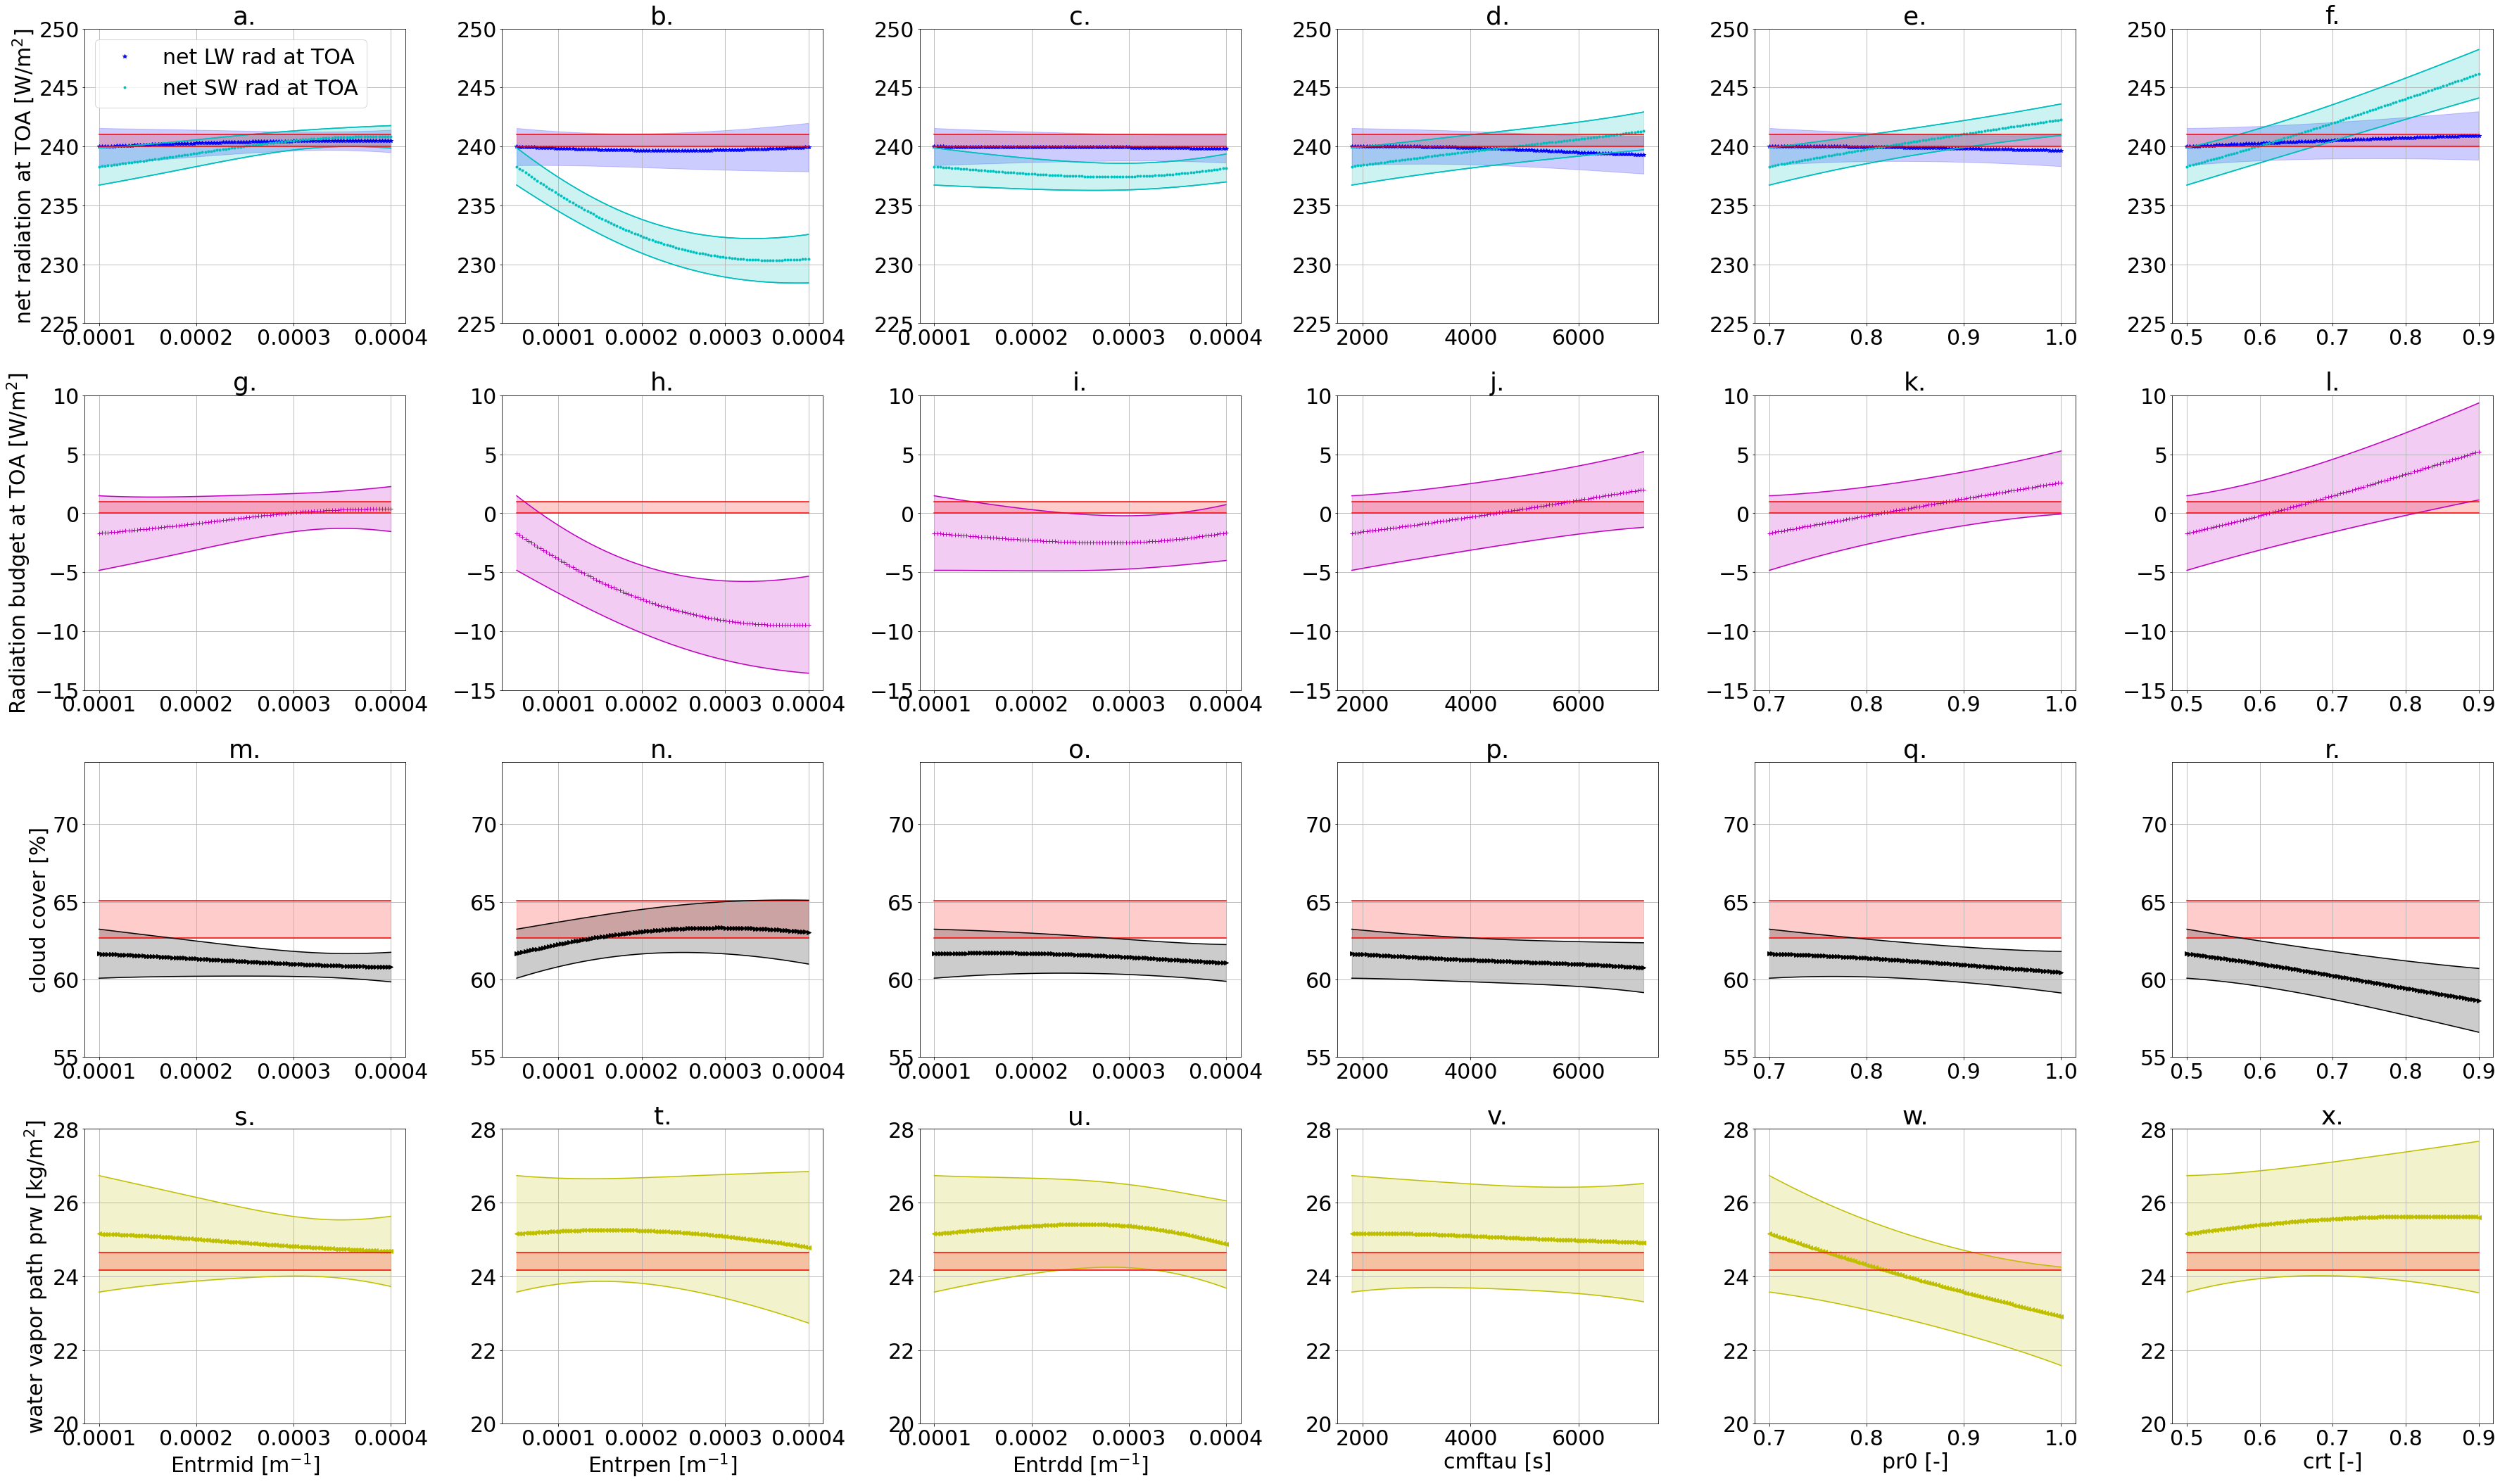

In [15]:
#Plot the param to output map
fontsize=30
plt.rcParams["legend.fontsize"] = fontsize
plt.rc('font', size=fontsize) 
plt.rcParams["axes.labelsize"] = fontsize
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['figure.figsize'] = [50, 30]

nn=8
N=1
#results=results_2ndPPE
trianglex = [ 240, 240, 241, 240 ] 
triangley = [ 240, 241, 241, 240 ]

labelssave=['Emid','Epen','Edd','Taumf', 'Pr', 'R0top']        
labelsp_latex=[r'$\epsilon_{mid}$ [m$^{-1}$]',r'$\epsilon_{pen}$ [m$^{-1}$]',r'$\epsilon_{dd}$ [m$^{-1}$]',r'$\tau_{mf}$ [s]', r'$Pr$ [-]', r'$r_{0,top}$ [-]']
labelsp=[r'Entrmid [m$^{-1}$]',r'Entrpen [m$^{-1}$]',r'Entrdd [m$^{-1}$]',r'cmftau [s]', r'pr0 [-]', r'crt [-]']
labelsNounits=[r'$\epsilon_{mid}$',r'$\epsilon_{pen}$',r'$\epsilon_{dd}$',r'$\tau_{mf}$', r'$Pr$', r'$r_{0,top}$']

labelsoutputs=[r'net SW radiation at TOA [W/m$^2$]',r'net LW radiation at TOA [W/m$^2$]',r'net radiation at TOA [W/m$^2$]',r'cloud cover [%]',r'water vapor path prw [kg/m$^2$]']
labelsoutputsnodim=[r'net SW rad at TOA',r'net LW rad at TOA',r'Radiative budget at TOA ',r'cloud cover',r'water vapor path prw ']

titles=['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.','k.','l.','m.','n.','o.','p.','q.','r.','s.','t.','u.','v.','w.','x.','y.']
colorsL=['c', 'b', 'm', 'k', 'y', 'gray','lightcoral', 'dodgerblue', 'blueviolet']
shapesL=['.', '*', '+', '>', '<', 's','-.', 'o']
shapestd='-'
colorref='r'
AA=0.2
whichparamval=[0] #mean of bounds values
FirstpartTitle='GP PPE results,'
meann0ALL={}
meann1ALL={}
meann2ALL={}
stdd0ALL={}
stdd1ALL={}
stdd2ALL={}
for ivar in [0,1,2,3,4,5]:
    meann0,stdd0 =automatic_mean_std_no(ivar,0)
    meann1,stdd1 =automatic_mean_std_no(ivar,1)
    meann2,stdd2 =automatic_mean_std_no(ivar,2)
    meann0ALL[ivar]=meann0
    meann1ALL[ivar]=meann1
    meann2ALL[ivar]=meann2
    stdd0ALL[ivar]=stdd0
    stdd1ALL[ivar]=stdd1
    stdd2ALL[ivar]=stdd2
meannall=[meann0ALL,meann1ALL,meann2ALL]
stddall=[stdd0ALL,stdd1ALL,stdd2ALL]
Ntotparam=6
fig = plt.figure()
for ivar in np.arange(0,Ntotparam):
    ccc=colors[ivar]

    v1=1
    v2=0
    v3=2
    ax = fig.add_subplot(4,Ntotparam,ivar+1)
    for indbounds in whichparamval:
        meann=meannall[indbounds][ivar]
        stdd=stddall[indbounds][ivar]
        synthe_alll=synthe_alll_sevboundno[indbounds]
        
        ax.plot(synthe_alll[ivar][:,ivar],-meann[:,v1],shapesL[v1],color=colorsL[v1],label=labelsoutputsnodim[v1])
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v2],shapesL[v2],color=colorsL[v2],label=labelsoutputsnodim[v2])

        ax.fill_between(synthe_alll[ivar][:,ivar],-meann[:,v1]+stdd[:,v1],-meann[:,v1]-stdd[:,v1],alpha=AA,color=colorsL[v1])
        ax.fill_between(synthe_alll[ivar][:,ivar],meann[:,v2]+stdd[:,v2],meann[:,v2]-stdd[:,v2],alpha=AA,color=colorsL[v2])

        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v2]+stdd[:,v2],shapestd,color=colors[v2])
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v2]-stdd[:,v2],shapestd,color=colors[v2])
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v2]+stdd[:,v2],shapestd,color=colors[v2])
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v2]-stdd[:,v2],shapestd,color=colors[v2])

        #plot reference values
        ax.fill_between([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[240,240],[241,241],alpha=AA,color=colorref)
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[240,240],'-',color=colorref)
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[241,241],'-',color=colorref)

    if ivar+1 in [1,7,13,19]:
        ax.set_ylabel(r'net radiation at TOA [W/m$^2$]')
        ax.legend(loc="upper left")
    if ivar+1 in [19,20,21,22,23,24]:
        ax.set_xlabel(labelsp[ivar])

    ax.set_ylim([225,250])
    ax.grid()
    ax.set_title(titles[ivar])

    ax = fig.add_subplot(4,Ntotparam,ivar+7)
    for indbounds in whichparamval:
        meann=meannall[indbounds][ivar]
        stdd=stddall[indbounds][ivar]
        synthe_alll=synthe_alll_sevboundno[indbounds]
        
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v1]+meann[:,v2],shapesL[v3],color=colorsL[v3],label=labelsoutputs[v3])
        ax.fill_between(synthe_alll[ivar][:,ivar],meann[:,v1]+meann[:,v2]+stdd[:,v1]+stdd[:,v2],meann[:,v1]+meann[:,v2]-stdd[:,v1]-stdd[:,v2],alpha=AA,color=colorsL[v3])
        
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v1]+meann[:,v2]+stdd[:,v1]+stdd[:,v2],shapestd,color=colorsL[v3])
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v1]+meann[:,v2]-stdd[:,v1]-stdd[:,v2],shapestd,color=colorsL[v3])

        #plot reference values
        ax.fill_between([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[0,0],[1,1],alpha=AA,color=colorref)
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[0,0],'-',color=colorref)
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[1,1],'-',color=colorref)

    
    if ivar+7 in [1,7,13,19]:
        ax.set_ylabel(r'Radiation budget at TOA [W/m$^2$]')
    if ivar+7 in [19,20,21,22,23,24]:
        ax.set_xlabel(labelsp[ivar])
    
    #ax.legend(loc="upper left")
    ax.set_ylim([-15,10])
    ax.grid()
    ax.set_title(titles[ivar+6])

    ax = fig.add_subplot(4,Ntotparam,ivar+13)
    v4=3
    #results=results_2ndPPE
    Ns=1

    for indbounds in whichparamval:
        meann=meannall[indbounds][ivar]
        stdd=stddall[indbounds][ivar]
        synthe_alll=synthe_alll_sevboundno[indbounds]

        #plot reference values
        ax.fill_between([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[ref_Clt_CLARA_AVHRR,ref_Clt_CLARA_AVHRR], [ref_Clt_ESACCI,ref_Clt_ESACCI],alpha=AA, color=colorref) #,label='Ref. CERES, ERA-Interim')
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[ref_Clt_CLARA_AVHRR,ref_Clt_CLARA_AVHRR],'-', color=colorref) #,label='Ref. CERES, ERA-Interim')
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[ref_Clt_ESACCI,ref_Clt_ESACCI],'-', color=colorref) #,label='Ref. CERES, ERA-Interim')
        
        #plt.plot([24.6], [63.6], '^',color='orange',label='ICON-aes-1.3')

        plt.plot(synthe_alll[ivar][:,ivar],meann[:,v4],shapesL[v4],color=colorsL[v4],label=labelsoutputs[v4])
        
        ax.fill_between(synthe_alll[ivar][:,ivar],meann[:,v4]+stdd[:,v4],meann[:,v4]-stdd[:,v4],alpha=AA,color=colorsL[v4])
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v4]+stdd[:,v4],shapestd,color=colorsL[v4])
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v4]-stdd[:,v4],shapestd,color=colorsL[v4])
        
    ax.set_ylim([55,74])
    ax.grid()
    
    if ivar+13 in [1,7,13,19]:
        ax.set_ylabel(labelsoutputs[v4] )
    if ivar+13 in [19,20,21,22,23,24]:
        ax.set_xlabel(labelsp[ivar])
    
    #ax.legend(loc='upper right')
    ax.set_title(titles[ivar+12])
    
    ax = fig.add_subplot(4,Ntotparam,ivar+19)
    v5=4

    for indbounds in whichparamval:
        meann=meannall[indbounds][ivar]
        stdd=stddall[indbounds][ivar]
        synthe_alll=synthe_alll_sevboundno[indbounds]

        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v5],shapesL[v5],color=colorsL[v5],label=labelsoutputs[v5])

        ax.fill_between(synthe_alll[ivar][:,ivar],meann[:,v5]+stdd[:,v5],meann[:,v5]-stdd[:,v5],alpha=AA,color=colorsL[v5]) 
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v5]+stdd[:,v5],shapestd,color=colorsL[v5]) 
        ax.plot(synthe_alll[ivar][:,ivar],meann[:,v5]-stdd[:,v5],shapestd,color=colorsL[v5])
        
        #plot reference values
        ax.fill_between([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[ref_mean[4]-Ns*ref_std[4],ref_mean[4]-Ns*ref_std[4]], [ref_mean[4]+Ns*ref_std[4],ref_mean[4]+Ns*ref_std[4]],alpha=AA, color=colorref) #,label='Ref. CERES, ERA-Interim')
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[ref_mean[4]-Ns*ref_std[4],ref_mean[4]-Ns*ref_std[4]],'-', color=colorref) #,label='Ref. CERES, ERA-Interim')
        ax.plot([np.min(synthe_alll[ivar][:,ivar]),np.max(synthe_alll[ivar][:,ivar])],[ref_mean[4]+Ns*ref_std[4],ref_mean[4]+Ns*ref_std[4]],'-', color=colorref) #,label='Ref. CERES, ERA-Interim')

    ax.set_title(titles[ivar+18])
    if ivar+19 in [1,7,13,19]:
        ax.set_ylabel(labelsoutputs[v5] )
    if ivar+19 in [19,20,21,22,23,24]:
        ax.set_xlabel(labelsp[ivar])
    
    #ax.legend(loc='upper left')
    ax.set_ylim([20,28])
    ax.grid()
fig.tight_layout()
plt.show()
#fig.savefig('PaperFig/Output_wrt_Param_iniParam_PhyOutputs.png')